In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from qick import *

from qick.asm_v2 import AveragerProgramV2
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
import logging

logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.getLogger("qick_processor").setLevel(logging.WARNING)

## firmware
The regular buffer has two buffer sizes configurable in the firmware design:
* N_BUF: the decimated buffer size - this sets the total duration of decimated waveforms that can be recorded in a program
* N_AVG: the accumulated buffer size - this sets the number of readouts that can get stored in the buffer

Note that for the regular buffer, the length of each readout window is limited by N_BUF when using decimated readout (and if your program triggers the readout multiple times, all the data needs to fit in the buffer), but is almost unlimited when using accumulated readout (the number of samples has to fit in a 32-bit uint, and the accumulated I/Q values will overflow if they exceed a 32-bit int).

The weighted buffer adds one more:
* N_WGT: the weights buffer size - this sets the maximum duration of a readout window (decimated or accumulated), except in the special case of default weights (weights=None)

It will often make sense to set N_WGT equal to N_BUF, which lets you use the decimated readout to check the effect of your weights vector.
If you want to do long accumulated readouts you will need big N_WGT, and might want to conserve memory by setting N_BUF<N_WGT.
If your readout window is not that long but you want to do lots of decimated readouts (to calibrate your weighting function) you may want N_BUF>N_WGT.

This test firmware (https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2025-05-16_111_tprocv2r23_weightedbuf3/) has N_BUF>N_WGT, which is useful for testing.

In [3]:
# soc = QickSoc('../2025-03-02_111_tprocv2r21_standard_2/d_1.bit')
# soc = QickSoc('/data/fw/2025-05-12_111_tprocv2r23_weightedbuf/qick_111.bit')
# soc = QickSoc('/data/fw/2025-05-16_111_tprocv2r23_weightedbuf/qick_111.bit')
# soc = QickSoc('/data/fw/2025-05-16_111_tprocv2r23_weightedbuf2/qick_111.bit')
soc = QickSoc('/data/fw/2025-05-16_111_tprocv2r23_weightedbuf3/qick_111.bit')

soccfg = soc
print(soccfg)

QICK running on ZCU111, software version 0.2.334

Firmware configuration (built Fri May 16 21:45:00 2025):

	Global clocks (MHz): tProc dispatcher timing 409.600, RF reference 204.800
	Groups of related clocks: [tProc timing clock, DAC tile 1], [ADC tile 0]

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.000 us)
		fs=6553.600 Msps, fabric=409.600 MHz, 32-bit DDS, range=6553.600 MHz
		DAC tile 1, blk 2 is DAC229_T1_CH2 or RF board output 6
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.000 us)
		fs=6553.600 Msps, fabric=409.600 MHz, 32-bit DDS, range=6553.600 MHz
		DAC tile 1, blk 3 is DAC229_T1_CH3 or RF board output 7

	2 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 2
		fs=4096.000 Msps, decimated=512.000 MHz, 32-bit DDS, range=4096.000 MHz
		axis_avg_buffer v1.1 (has edge counter, no weights)
		memory 16384 accumulated, 4096 decimated (8.000 us)
		triggered by tport 10, pin 0, feedback to tProc input 0
		

In [4]:
RO_CHS = [0,1] # the first is a regular buffer, the second is weighted
GEN_CHS = [1,0] # two identical gens, the first is connected to the regular buffer and the second to the weighted
TRIG_TIME = 0.3 # us
FREQ = 500 # MHz

### without weights
If you don't specify weights, the weighted buffer loads "default" weights - a constant array of `2**15-2 + 0j` (the maximum possible value on the positive real axis). This gives the closest behavior to the regular readout buffer.

For each decimated sample, the weighted buffer multiplies two 16-bit complex numbers (the incoming data and the weight) and returns one 16-bit complex number (the weighted data); some bits have to be truncated away.
Currently, the choice has been made to keep all of the most-significant bits and truncate the least-significant bits.
This is the safest choice, since it prevents overflow even in the case where you have a weight like `(2**15-2)(1+j)`.
But if necessary, we could make the truncation user-configurable.

Anyway - here we play identical pulses on the two generators and look at the decimated data on the two readouts.
The weighted buffer reduces the amplitude by a factor of 2 due to the truncation discussed above.

In [5]:
class PulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_chs = cfg['gen_chs']
        for gen_ch in gen_chs:
            self.declare_gen(ch=gen_ch, nqz=1)
            
        self.add_pulse(ch=gen_chs,
                      name="mypulse",
                      ro_ch=ro_chs[0],
                      style="const",
                      freq=cfg['freq'],
                      length=cfg['pulse_len'],
                      phase=cfg['phase'],
                      gain=cfg['gain'],
                      )

        for ro_ch in ro_chs:
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_chs,
                              name="myro",
                              freq=cfg['freq'],
                              gen_ch=gen_chs[0])

        for ro_ch in ro_chs:
            self.send_readoutconfig(ch=ro_ch,
                                   name="myro",
                                   t=0)

    def _body(self, cfg):
        self.delay(1.0)
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="mypulse", t=0)
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)

  0%|          | 0/1 [00:00<?, ?it/s]

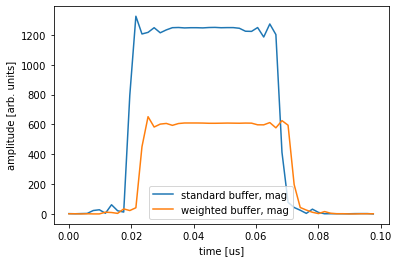

In [6]:
config = \
{
    'gen_chs': GEN_CHS,
    'ro_chs': RO_CHS,
    'freq': FREQ,
    'trig_time': TRIG_TIME,
    'ro_len': 0.1,
    'pulse_len': 0.05,
    'gain': 1.0,
    'phase': 0.0
}

prog = PulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
fig = plt.figure()
plt.plot(t, np.abs(iq_list[0].dot([1, 1j])), label='standard buffer, mag')
plt.plot(t, np.abs(iq_list[1].dot([1, 1j])), label='weighted buffer, mag')
# plt.plot(t, iq_list[0][:,0], label='standard buffer, I')
# plt.plot(t, iq_list[0][:,1], label='standard buffer, Q')
# plt.plot(t, iq_list[1][:,0], label='weighted buffer, I')
# plt.plot(t, iq_list[1][:,1], label='weighted buffer, Q')

plt.xlabel('time [us]')
plt.ylabel('amplitude [arb. units]')
plt.legend();

### with weights
Now let's just look at the weighted buffer - let's play a continuous tone and look at the effects of different weight arrays.

In [7]:
class CWProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=1)
            
        self.add_pulse(ch=gen_ch,
                      name="mypulse",
                      ro_ch=ro_ch,
                      style="const",
                      freq=cfg['freq'],
                      length=cfg['pulse_len'],
                      phase=cfg['phase'],
                      gain=cfg['gain'],
                      mode='periodic'
                      )

        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], weights=cfg['weights'])

        self.add_readoutconfig(ch=ro_ch,
                              name="myro",
                              freq=cfg['freq'],
                              gen_ch=gen_ch)

        self.send_readoutconfig(ch=ro_ch,
                               name="myro",
                               t=0)

        self.pulse(ch=gen_ch, name="mypulse", t=0)

    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
    
    def _cleanup(self, cfg):
        # special zero-gain "dummy pulse" to stop periodic pulses
        self.pulse(ch=cfg['gen_ch'], name="dummypulse", t=0)

In [8]:
def plot_weighted_data(weights, data):
    fig = plt.figure()
    plt.plot(weights[:,0], label='weights, I', color='green')
    plt.plot(weights[:,1], label='weights, Q', color='red')
    plot = fig.axes[0]
    wmax = np.abs(weights).max()
    plot.set_ylim((-1.2*wmax, 1.2*wmax))
    plot.set_xlabel("time [samples]")
    plot.set_ylabel("weights [arb. units]")

    ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(data[:,0], label='weighted data, I')
    ax2.plot(data[:,1], label='weighted data, Q')
    dmax = np.abs(data).max()
    ax2.set_ylim((-1.1*dmax, 1.1*dmax))
    ax2.set_ylabel("data [arb. units]")

    # combine the legends: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
    lines, labels = plot.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2);

We'll calibrate the phase to put the signal on the positive imaginary axis.

Note that you now have three places where you can apply phase rotations:
* all generators have a configurable upconversion phase, I think (you could also supply a complex envelope)
* most (all?) readouts have a configurable downconversion phase
* you could supply complex weights to the weighted buffer 

In [9]:
config = \
{
    'gen_ch': GEN_CHS[1],
    'ro_ch': RO_CHS[1],
    'freq': FREQ,
    'trig_time': TRIG_TIME,
    'ro_len': 0.1,
    'weights': None,
    'pulse_len': 0.1,
    'gain': 1.0,
    'phase': 0.0
}
prog = CWProgram(soccfg, reps=10, final_delay=0.5, cfg=config)
iq_data = prog.acquire(soc)

phase_offset = np.angle(iq_data[0][0].dot([1, 1j]), deg=True)
config['phase'] = 90-phase_offset
print("set the generator phase to %f degrees"%(config['phase']))

  0%|          | 0/10 [00:00<?, ?it/s]

set the generator phase to -33.423107 degrees


Test that the weights array is aligned with the data: we put a ramp in the weights and see that it appears in the data without any glitches or time offset.

  0%|          | 0/1 [00:00<?, ?it/s]

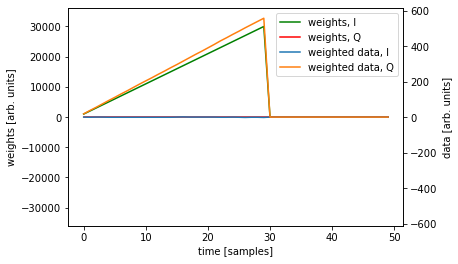

In [10]:
buflen = 50
config['ro_len'] = soccfg.cycles2us(buflen, ro_ch=RO_CHS[1])

weights = np.zeros((buflen,2), dtype=np.int16)
weights[:30,0] = (np.arange(30)+1)*1000
config['weights'] = weights

prog = CWProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

plot_weighted_data(weights, iq_list[0])

Demonstrate that we can use weights to apply a rotating phase to the incoming signal.
Note that because the incoming data is imaginary, the weights and the weighted data are 90 degrees out of phase.

  0%|          | 0/1 [00:00<?, ?it/s]

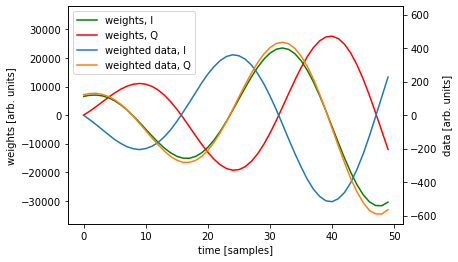

In [11]:
buflen = 50
config['ro_len'] = soccfg.cycles2us(buflen, ro_ch=RO_CHS[1])

weights = np.zeros((buflen,2), dtype=np.int16)
# weights[:,0] = np.cos(0.1*np.arange(buflen))*(2**15-2)
# weights[:,1] = np.sin(0.1*np.arange(buflen))*(2**15-2)
w = np.exp(0.2j*np.arange(buflen)) * np.linspace(0.2, 1.0, buflen)
weights[:,0] = np.real(w)*(2**15-2)
weights[:,1] = np.imag(w)*(2**15-2)

config['weights'] = weights

prog = CWProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

plot_weighted_data(weights, iq_list[0])

Another test.
You can't load a weights array longer than the weights memory, and normally the software will not let you declare a readout window that differs from the length of your weights array. But if you use the "default" weights, you can have a big readout window - how?

When the readout window is longer than the weights memory, the weighted buffer loops through the weights memory repeatedly.
This is not useful behavior generally, but if the weights array is constant this is fine.

Let's confirm this behavior.
First, define a max-length weights array with a linear ramp.

  0%|          | 0/1 [00:00<?, ?it/s]

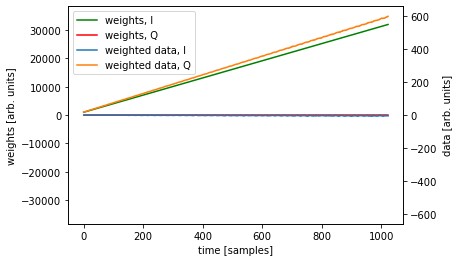

In [12]:
buflen = soccfg['readouts'][RO_CHS[1]]['wgt_maxlen']
config['ro_len'] = soccfg.cycles2us(buflen, ro_ch=RO_CHS[1])

weights = np.zeros((buflen,2), dtype=np.int16)
weights[:,0] = np.linspace(1000, 32000, buflen)

# weights[1:,0] = 32000
# weights[:30,0] = (np.arange(30)+1)*1000
config['weights'] = weights

prog = CWProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

plot_weighted_data(weights, iq_list[0])

Now make the readout window three times as long, with default weights - this is a valid program because of the default weights.
Load the program with `load_pulses=False`, which disables loading of weights (and pulse envelopes, but we're not using those in this program).
This means that the ramp we loaded in the previous program won't get overwritten with default weights.

We see the ramp repeats during the readout window.

  0%|          | 0/1 [00:00<?, ?it/s]

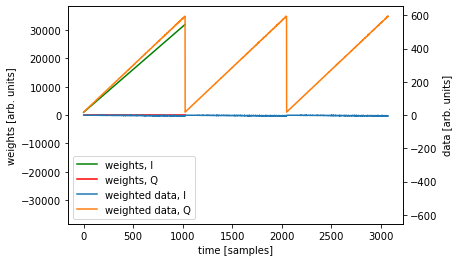

In [13]:
buflen = soccfg['readouts'][RO_CHS[1]]['wgt_maxlen']*3
config['ro_len'] = soccfg.cycles2us(buflen, ro_ch=RO_CHS[1])

config['weights'] = None

prog = CWProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

# load_pulses=False disables loading of the weights
iq_list = prog.acquire_decimated(soc, soft_avgs=1, load_envelopes=False)
# t = prog.get_time_axis(ro_index=0)

plot_weighted_data(weights, iq_list[0])